# Example of clusteting/ extraction using TSFRESH on the m5 dataset 
author : Killian Pitiot

In [12]:
# Tsfresh timeseries clustering
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import json
import os
import gc
from pathlib import Path
import seaborn as sns 

from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [13]:

limit_ts = 10000
m5_input_path = './data/raw'
path = f'{m5_input_path}/sales_train_validation.csv'


In [18]:
# function for features extractions: 
def form_path_to_ts_pure(path):
    df = pd.read_csv(path)
    # Change the dataframe to the tsfresh format 
    df = df.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1)

    # start the pivoting of the dataframe in order to get it to the format 
    columns = df.id.values 
    print(f"Number of series {columns.shape[0]}")

    return df 

def form_path_to_ts(path,limit_series=10000):
    df = pd.read_csv(f'{m5_input_path}/sales_train_validation.csv')
    # Change the dataframe to the tsfresh format 
    df = df.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1)

    # start the pivoting of the dataframe in order to get it to the format 
    columns = df.id.values 
    print(f"Number of series {columns.shape[0]}")
    df = pd.DataFrame(columns=columns[:limit_series],data=df.iloc[:limit_series,1:].transpose().values)
    df = df.reset_index().melt(id_vars='index')
    return df 
  
default_fc_parameters = EfficientFCParameters() #  can be replaced with a dict of the features 
default_fc_parameters = MinimalFCParameters()
def df_extract_features(df):
    X = extract_features(df,
        column_id ='variable',
        column_sort = 'index',
        column_value="value",
        default_fc_parameters = default_fc_parameters,
        n_jobs =4,
        )
    return X 
    

# Start the clustering process 

In [19]:
# perform the feature extraction 
df = form_path_to_ts(path,limit_ts)
X  = df_extract_features(df)
X_scaled = MinMaxScaler().fit_transform(X.fillna(-1))

Number of series 30490


Feature Extraction: 100%|███████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.50it/s]


In [20]:
X.head()

variable,value__length,value__maximum,value__mean,value__median,value__minimum,value__standard_deviation,value__sum_values,value__variance
id,,,,,,,,
FOODS_1_001_CA_1_validation,1913.0,15.0,0.785677,0.0,0.0,1.257726,1503.0,1.581875
FOODS_1_001_CA_2_validation,1913.0,16.0,1.157344,1.0,0.0,1.761474,2214.0,3.102791
FOODS_1_001_CA_3_validation,1913.0,24.0,1.203346,0.0,0.0,2.346144,2302.0,5.504390
FOODS_1_002_CA_1_validation,1913.0,8.0,0.477784,0.0,0.0,0.803581,914.0,0.645743
FOODS_1_002_CA_2_validation,1913.0,8.0,0.603241,0.0,0.0,0.999702,1154.0,0.999404


In [21]:
# start computing the TSNE on the extracted features 
time_start = time.time()
tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40,
            n_iter=500,
           n_jobs = -1)
tsne_results = tsne.fit_transform(X_scaled)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 0.263s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000256
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.298897
[t-SNE] KL divergence after 500 iterations: 0.883335
t-SNE done! Time elapsed:

### For the demo, a lot of non relevent features has been computed 

Text(0.5, 0, 'TSNE 2')

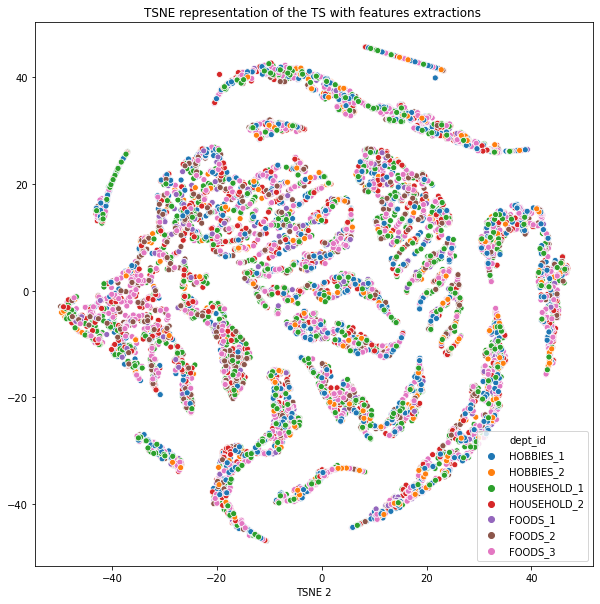

In [22]:
plt.figure(figsize=(10,10))
cat = 'dept_id'
sns.scatterplot(x=tsne_results[:,0],
                y=tsne_results[:,1],
                hue=pd.read_csv(path)[cat][:10000]
               )
plt.title('TSNE representation of the TS with features extractions ')
plt.xlabel('TSNE 1')
plt.xlabel('TSNE 2')

# TSNE with DTW

- use the DTW distance to find cluster 
- Need to be used with low dimensionnal data 

In [8]:
df_ts = form_path_to_ts_pure(path)

Number of series 30490


In [9]:
# plotting with pure ts 
from scipy.spatial import distance

def DTW(a, b): 
    '''
    Pure python implementation of the DTW... need to be cythonized 
    '''
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

In [10]:
# start computing the TSNE on the extracted features 

time_start = time.time()
tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40,
            #metric=DTW, # too long in pure python 
            n_iter=250,
           n_jobs = -1)

tsne_results = tsne.fit_transform(df_ts.iloc[:10000,1:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 4.444s...
[t-SNE] Computed neighbors for 10000 samples in 61.608s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.507499
[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.601471
[t-SNE] KL divergence after 251 iterations: 17976931348623157081452742373170

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1],s=10,alpha=.7)
plt.title('TSNE representation of the TS with features extractions ')
plt.xlabel('TSNE 1')
plt.xlabel('TSNE 2')